# SC2 Pre-sort Checks

Supports **tetrode** and **mixed** pipelines. Set `PIPELINE_MODE` in the imports cell.
Suggested run order: top to bottom; optional sections are marked.
Tetrode-only sections run only when `RUN_TETRODE_CHECKS` is True.


### Imports and setup
Load packages, select the pipeline module, and set defaults.

Note: scaled traces are for visualization only; sorting uses native/raw units.


In [37]:
from pathlib import Path
import sys
from importlib import import_module
import numpy as np
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
from spikeinterface.sorters import Spykingcircus2Sorter
import matplotlib.pyplot as plt

# Pipeline mode.
PIPELINE_MODE = 'tetrode'  # 'tetrode' or 'mixed'
PIPELINE_MODULE = 'spikeinterface_sc2_tet_pipeline' if PIPELINE_MODE == 'tetrode' else 'spikeinterface_sc2_mixed_pipeline'

# Optional runtime overrides.
FORCE_TETRODE_CHECKS = None  # set True/False to override auto mode
SKIP_NOISY_CELLS = False  # set True to skip heavy/plotting cells
RUN_TETRODE_CHECKS = (PIPELINE_MODE == 'tetrode') if FORCE_TETRODE_CHECKS is None else FORCE_TETRODE_CHECKS

# Resolve project root for notebook imports.
PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))
pipe = import_module(f'Pipelines.{PIPELINE_MODULE}')
print('Using pipeline:', pipe.__file__)
from Functions.pipeline_utils import safe_channel_slice
from Functions.si_utils import set_group_property


def get_traces_raw(recording, *args, **kwargs):
    # Prefer unscaled/raw traces.
    if 'return_scaled' in kwargs:
        kwargs.pop('return_scaled', None)
        kwargs['return_in_uV'] = False
    if 'return_in_uV' not in kwargs:
        kwargs['return_in_uV'] = False
    return recording.get_traces(*args, **kwargs)

def get_traces_scaled(recording, *args, **kwargs):
    # Prefer uV-scaled traces when available.
    if 'return_scaled' in kwargs:
        kwargs.pop('return_scaled', None)
        kwargs['return_in_uV'] = True
    if 'return_in_uV' in kwargs:
        kwargs['return_in_uV'] = True
    else:
        kwargs['return_in_uV'] = True
    return recording.get_traces(*args, **kwargs)

def scale_to_uV(recording):
    try:
        gains = recording.get_channel_gains()
    except Exception:
        gains = None
    try:
        offsets = recording.get_channel_offsets()
    except Exception:
        offsets = None
    if gains is None:
        print('scale_to_uV: channel gains not found; returning recording unchanged.')
        return recording
    gains_arr = np.asarray(gains)
    if offsets is None:
        offsets_arr = np.zeros_like(gains_arr, dtype='float32')
    else:
        offsets_arr = np.asarray(offsets)
        if offsets_arr.shape != gains_arr.shape:
            offsets_arr = np.zeros_like(gains_arr, dtype='float32')
    return spre.scale(recording, gain=gains_arr, offset=offsets_arr, dtype='float32')


Using pipeline: C:\Users\ryoi\Documents\Code\SpikeSorting\Pipelines\spikeinterface_sc2_tet_pipeline.py


In [50]:
# Reload pipeline modules to pick up recent edits.
import importlib
import Functions.pipeline_utils as pu

pipe = importlib.import_module(f'Pipelines.{PIPELINE_MODULE}')
importlib.reload(pu)
importlib.reload(pipe)
print('pipe file:', pipe.__file__)


Note: bad_channels empty; using pipe.BAD_CHANNELS
pipe file: C:\Users\ryoi\Documents\Code\SpikeSorting\Pipelines\spikeinterface_sc2_tet_pipeline.py
BAD_CHANNELS: ['CH7', 'CH2', 'CH26', 'CH4', 'CH42', 'CH50', 'CH51', 'CH52', 'CH54', 'CH56', 'CH6', 'CH8'] len: 12


## Quick status check (mode + flags)


In [38]:
# Status: confirm active pipeline mode and run flags before running checks.
print(f'PIPELINE_MODE={PIPELINE_MODE} | RUN_TETRODE_CHECKS={RUN_TETRODE_CHECKS} | SKIP_NOISY_CELLS={SKIP_NOISY_CELLS}')


PIPELINE_MODE=tetrode | RUN_TETRODE_CHECKS=True | SKIP_NOISY_CELLS=False


### Version snapshot
Print key package versions for reproducibility and API context.


In [39]:
import spikeinterface as si

print("=== Version & Dependency Check ===")
# Optional dependency check (SC2 matched filtering + clustering).
try:
    import numba
    numba_ver = getattr(numba, "__version__", "unknown")
except Exception as exc:
    numba_ver = None
    print(f"numba: not available ({exc})")

try:
    import hdbscan
    hdbscan_ver = getattr(hdbscan, "__version__", "unknown")
except Exception as exc:
    hdbscan_ver = None
    print(f"hdbscan: not available ({exc})")

print("python:", sys.version.split()[0])
print("numpy:", np.__version__)
print("spikeinterface:", si.__version__)
if numba_ver or hdbscan_ver:
    print(f"numba: {numba_ver} | hdbscan: {hdbscan_ver}")


=== Version & Dependency Check ===
python: 3.11.14
numpy: 2.3.4
spikeinterface: 0.103.2
numba: 0.62.1 | hdbscan: unknown


### SC2 default parameters
Show SpyKING CIRCUS 2 defaults for reference.


Note: In the SpikeInterface SC2 wrapper, `apply_preprocessing` controls bandpass/CMR; whitening is still applied internally.


In [40]:
import json

params = Spykingcircus2Sorter.default_params()
print(json.dumps(params, indent=2))


{
  "general": {
    "ms_before": 0.5,
    "ms_after": 1.5,
    "radius_um": 100.0
  },
  "filtering": {
    "freq_min": 150,
    "freq_max": 7000,
    "ftype": "bessel",
    "filter_order": 2,
    "margin_ms": 20
  },
  "whitening": {
    "mode": "local",
    "regularize": false
  },
  "detection": {
    "method": "matched_filtering",
    "method_kwargs": {
      "peak_sign": "neg",
      "detect_threshold": 5
    },
    "pipeline_kwargs": {}
  },
  "selection": {
    "method": "uniform",
    "method_kwargs": {
      "n_peaks_per_channel": 5000,
      "min_n_peaks": 100000,
      "select_per_channel": false
    }
  },
  "apply_motion_correction": true,
  "motion_correction": {
    "preset": "dredge_fast"
  },
  "merging": {
    "max_distance_um": 50
  },
  "clustering": {
    "method": "iterative-hdbscan",
    "method_kwargs": {}
  },
  "cleaning": {
    "min_snr": 5,
    "max_jitter_ms": 0.1,
    "sparsify_threshold": null
  },
  "matching": {
    "method": "circus-omp",
    "method_

### SC2 params in use
Print the key SC2 preprocessing flags used here.


In [41]:
try:
    params = pipe.get_sc2_default_params()
except Exception:
    params = Spykingcircus2Sorter.default_params()

print("apply_preprocessing:", params.get("apply_preprocessing"))
print("whitening:", params.get("whitening"))


apply_preprocessing: True
whitening: {'mode': 'local', 'regularize': False}


### Optional JSON overrides
Load channel group and bad-channel overrides (if provided).


In [42]:
# Tetrode-only. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping tetrode-only cell (set RUN_TETRODE_CHECKS=True to run).')
else:
    import os

    channel_groups_path = None  # e.g., Path('SpikeSorting/config/channel_groups_tetrodes.json')
    bad_channels_path = None  # e.g., Path('SpikeSorting/config/bad_channels_tetrodes.json')

    manual_groups = pipe.CHANNEL_GROUPS
    groups_source = 'inline CHANNEL_GROUPS'
    env_groups_path = os.environ.get('SPIKESORT_CHANNEL_GROUPS', None)
    config_groups_path = getattr(pipe, 'CHANNEL_GROUPS_PATH', None)

    for label, path in [('env', env_groups_path), ('config', config_groups_path), ('notebook', channel_groups_path)]:
        loaded = pipe.load_channel_groups_from_path(path) if path else None
        if loaded:
            manual_groups = loaded
            groups_source = f'{label} file {path}'

    bad_channels = pipe.BAD_CHANNELS
    bad_source = 'inline BAD_CHANNELS'
    env_bad_path = os.environ.get('SPIKESORT_BAD_CHANNELS', None)
    config_bad_path = getattr(pipe, 'BAD_CHANNELS_PATH', None)

    for label, path in [('env', env_bad_path), ('config', config_bad_path), ('notebook', bad_channels_path)]:
        loaded = pipe.load_bad_channels_from_path(path) if path else None
        if loaded is not None:
            bad_channels = loaded
            bad_source = f'{label} file {path}'
            if len(loaded) == 0:
                print(f'Warning: bad channel list from {label} file {path} is empty')


    # If override is empty, fall back to inline BAD_CHANNELS.
    if (bad_channels is None or len(bad_channels) == 0) and pipe.BAD_CHANNELS:
        if bad_source != 'inline BAD_CHANNELS':
            print('Warning: bad channels override empty; using inline BAD_CHANNELS')
        bad_channels = pipe.BAD_CHANNELS
        bad_source = 'inline BAD_CHANNELS'

    print('Groups source:', groups_source)
    print('Bad channels source:', bad_source)


Groups source: inline CHANNEL_GROUPS
Bad channels source: inline BAD_CHANNELS


### Find sessions
List available Open Ephys recording folders under `root_dir`.
Expected: a numbered list of session folders.


In [43]:
# Session selection defaults (override as needed).
root_dir = getattr(pipe, 'DEFAULT_ROOT_DIR', PROJECT_ROOT / 'SpikeSorting' / 'recordings')
session_subpath = getattr(pipe, 'SESSION_SUBPATH', None)
session_selection = getattr(pipe, 'SESSION_SELECTION', 'prompt')
session_index = 0
stream_name = getattr(pipe, 'STREAM_NAME', None)
base_out = getattr(pipe, 'DEFAULT_BASE_OUT', PROJECT_ROOT)

print('Session defaults:')
print(f'  root_dir={root_dir}')
print(f'  session_subpath={session_subpath}')
print(f'  session_selection={session_selection}')
print(f'  session_index={session_index}')
print(f'  stream_name={stream_name}')
print(f'  base_out={base_out}')


Session defaults:
  root_dir=C:\Users\ryoi\Documents\Code\SpikeSorting\recordings
  session_subpath=None
  session_selection=prompt
  session_index=0
  stream_name=None
  base_out=C:\Users\ryoi\Documents\Code\SpikeSorting


In [44]:
from Functions.pipeline_utils import discover_recording_folders

folders = discover_recording_folders(root_dir)
print('found sessions:', len(folders))
for idx, path in enumerate(folders):
    rel = path.relative_to(root_dir)
    print(f"[{idx}] {rel}")


found sessions: 4
[0] 2025-05-09_15-15-57\Record Node 125\experiment2\recording1
[1] 2025-10-01_15-53-19\Record Node 125\experiment1\recording1
[2] 2025-12-10_15-32-18\Record Node 125\experiment2\recording1
[3] 2026-01-21_15-49-07\Record Node 125\experiment1\recording1


### Choose session and stream
Select the session and data stream (mirrors pipeline behavior).
Expected: printed `data_path` and `stream` values.


In [45]:
try:
    data_path = pipe.choose_recording_folder(root_dir, session_subpath, session_selection, session_index)
except Exception as exc:
    raise RuntimeError(f'choose_recording_folder failed: {exc}')

stream = pipe.pick_stream(data_path, stream_name)
print('data_path:', data_path)
print('stream:', stream)


Available sessions:
  [0] 2025-05-09_15-15-57\Record Node 125\experiment2\recording1 (modified 2026-01-30 10:07:10)
  [1] 2025-10-01_15-53-19\Record Node 125\experiment1\recording1 (modified 2025-10-21 17:45:09)
  [2] 2025-12-10_15-32-18\Record Node 125\experiment2\recording1 (modified 2025-12-11 18:40:49)
  [3] 2026-01-21_15-49-07\Record Node 125\experiment1\recording1 (modified 2026-01-24 11:29:07)
data_path: C:\Users\ryoi\Documents\Code\SpikeSorting\recordings\2025-12-10_15-32-18\Record Node 125\experiment2\recording1
stream: Record Node 125#Acquisition_Board-100.Rhythm Data


### Load recording
Read the Open Ephys data into a SpikeInterface extractor.
Expected: a recording summary (segments, Fs, channel count).


In [46]:
recording = se.read_openephys(data_path, stream_name=stream)
print(recording)
print('segments:', recording.get_num_segments(), 'Fs:', recording.get_sampling_frequency(), 'channels:', recording.get_num_channels())
if recording.get_num_segments() > 1:
    recording = recording.select_segments([0])
    print('Selected segment 0 (single segment).')


OpenEphysBinaryRecordingExtractor: 64 channels - 30.0kHz - 1 segments - 106,425,856 samples 
                                   3,547.53s (59.13 minutes) - int16 dtype - 12.69 GiB
segments: 1 Fs: 30000.0 channels: 64


### Input validation
Basic checks before sorting to catch obvious issues early.


In [47]:
# Tetrode-only. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping tetrode-only cell (set RUN_TETRODE_CHECKS=True to run).')
else:
    # Basic input validation.
    fs = recording.get_sampling_frequency()
    n_channels = recording.get_num_channels()
    n_segments = recording.get_num_segments()

    print(f"Sampling frequency: {fs} Hz")
    if fs < 1000:
        print("Warning: Low sampling frequency (< 1000 Hz) may affect spike detection.")
    elif fs > 50000:
        print("Warning: Very high sampling frequency (> 50 kHz) may increase computation time.")

    print(f"Number of channels: {n_channels}")
    if n_channels % 4 != 0:
        print("Warning: Number of channels not divisible by 4; may not align with tetrode setup.")

    print(f"Number of segments: {n_segments}")
    if n_segments > 1:
        print("Note: Multi-segment recording detected; ensure segments are handled correctly.")

    # Try auto-detecting bad channels if enabled.
    try:
        bad_channels = pipe.detect_bad_channel_ids(recording, pipe.AUTO_BAD_CHANNELS, method=getattr(pipe, "AUTO_BAD_CHANNELS_METHOD", None), **getattr(pipe, "AUTO_BAD_CHANNELS_KWARGS", {}))
        bad_ratio = len(bad_channels) / n_channels if n_channels else 0
        print(f"Auto-detected bad channels: {len(bad_channels)} ({bad_ratio:.1%})")
        if bad_ratio > 0.5:
            print("Warning: High proportion of bad channels (> 50%); consider manual inspection.")
    except Exception as e:
        print(f"Could not auto-detect bad channels: {e}")

    print("Input validation complete.")


Sampling frequency: 30000.0 Hz
Number of channels: 64
Number of segments: 1
Auto-detected bad channels: 0 (0.0%)
Input validation complete.


### Raw vs scaled trace sanity check
Compare native vs scaled traces for dtype/range/gain consistency.
Expected: dtype/min/max/std for raw and scaled traces.


In [48]:
fs = recording.get_sampling_frequency()
n_frames = int(fs)
try:
    raw = get_traces_raw(recording, start_frame=0, end_frame=n_frames)
    print("raw dtype:", raw.dtype, "min/max:", float(raw.min()), float(raw.max()), "std:", float(raw.std()))
except Exception as exc:
    print("raw trace read failed:", exc)
    raw = None

try:
    scaled = get_traces_scaled(recording, start_frame=0, end_frame=n_frames)
    print("scaled dtype:", scaled.dtype, "min/max:", float(scaled.min()), float(scaled.max()), "std:", float(scaled.std()))
except Exception as exc:
    print("scaled trace read failed:", exc)
    scaled = None

try:
    units = recording.get_channel_units() if hasattr(recording, "get_channel_units") else None
except Exception:
    units = None
try:
    gain_prop = "gain_to_uV" in recording.get_property_keys()
except Exception:
    gain_prop = False
try:
    gains = recording.get_channel_gains() if hasattr(recording, "get_channel_gains") else None
except Exception:
    gains = None

if units is None:
    print("channel units: not provided")
else:
    try:
        unique_units = sorted({str(u) for u in units})
    except Exception:
        unique_units = units
    print("channel units (unique):", unique_units)
print("gain_to_uV property present:", gain_prop)
if gains is not None:
    try:
        print("gains[0:5]:", gains[:5])
    except Exception:
        print("gains:", gains)

if raw is not None and scaled is not None:
    raw_med = float(np.median(np.abs(raw))) if raw.size else 0.0
    scaled_med = float(np.median(np.abs(scaled))) if scaled.size else 0.0
    if raw_med > 0:
        print("median |scaled| / |raw|:", scaled_med / raw_med)

# Native trace clipping check.
if raw is not None and raw.size:
    if np.issubdtype(raw.dtype, np.integer):
        min_val = np.iinfo(raw.dtype).min
        max_val = np.iinfo(raw.dtype).max
        pct_min = float(np.mean(raw == min_val) * 100.0)
        pct_max = float(np.mean(raw == max_val) * 100.0)
        print(f"raw dtype: {raw.dtype} | % at min: {pct_min:.4f}% | % at max: {pct_max:.4f}%")


raw dtype: int16 min/max: -5386.0 5715.0 std: 1166.442907999353
scaled dtype: float32 min/max: -1050.27001953125 1114.4249267578125 std: 227.45635986328125
channel units: not provided
gain_to_uV property present: True
gains[0:5]: [0.19499999 0.19499999 0.19499999 0.19499999 0.19499999]
median |scaled| / |raw|: 0.1949999974778861
raw dtype: int16 | % at min: 0.0000% | % at max: 0.0000%


### Channel IDs and labels
Print a quick preview of channel IDs and names.
Expected: a short list of channel_ids and channel_name values.
If you need a full index->id/name map, temporarily re-enable the next cell.


In [49]:
try:
    ch_ids = list(recording.channel_ids)
    print('channel_ids (first 10):', ch_ids[:10])
    if 'channel_name' in recording.get_property_keys():
        ch_names = list(recording.get_property('channel_name'))
        print('channel_name (first 10):', ch_names[:10])
    else:
        print('channel_name property not present')
except Exception as exc:
    print('channel id/name check failed:', exc)


channel_ids (first 10): [np.str_('CH40'), np.str_('CH38'), np.str_('CH36'), np.str_('CH34'), np.str_('CH48'), np.str_('CH46'), np.str_('CH44'), np.str_('CH42'), np.str_('CH56'), np.str_('CH54')]
channel_name (first 10): [np.str_('CH40'), np.str_('CH38'), np.str_('CH36'), np.str_('CH34'), np.str_('CH48'), np.str_('CH46'), np.str_('CH44'), np.str_('CH42'), np.str_('CH56'), np.str_('CH54')]


### Resolve bad channels
Combine manual + optional auto bad-channel detection.
Expected: bad channel IDs plus index list and remaining channel count.


In [51]:
# Resolve manual/auto bad channels.
if 'bad_channels' not in globals() or bad_channels is None or len(bad_channels) == 0:
    print('Note: bad_channels empty; using inline BAD_CHANNELS from pipeline')
    bad_channels = pipe.BAD_CHANNELS

manual_bad = pipe.resolve_bad_channel_ids(recording, bad_channels)
auto_bad = pipe.detect_bad_channel_ids(recording, pipe.AUTO_BAD_CHANNELS)
channel_order = list(recording.channel_ids)
index_map = {str(ch): idx for idx, ch in enumerate(channel_order)}

# Sort by original channel index for readability.
manual_sorted = sorted(manual_bad, key=lambda ch: index_map.get(str(ch), 1e9))
auto_sorted = sorted(auto_bad, key=lambda ch: index_map.get(str(ch), 1e9))

print("Bad channels removed:", manual_sorted)
if pipe.AUTO_BAD_CHANNELS:
    print(f"Auto-detected bad channels ({len(auto_sorted)}):", auto_sorted)
elif auto_sorted:
    print(f"Auto detection disabled; ignoring detected list: {auto_sorted}")

channel_dtype = np.asarray(channel_order).dtype if channel_order else object
bad_arrays = [np.array(arr, dtype=channel_dtype) for arr in (manual_sorted, auto_sorted) if np.asarray(arr).size]
if bad_arrays:
    bad_ids = np.unique(np.concatenate(bad_arrays))
    bad_indices = sorted([index_map[str(ch)] for ch in bad_ids if str(ch) in index_map])
else:
    bad_ids = np.array([], dtype=channel_dtype)
    bad_indices = []

remaining = len(channel_order) - len(bad_ids)
print("Corresponding indices:", bad_indices)
print("Remaining channels after removal:", remaining)


Bad channels removed: ['CH42', 'CH56', 'CH54', 'CH52', 'CH50', 'CH51', 'CH7', 'CH4', 'CH6', 'CH8', 'CH2', 'CH26']
Corresponding indices: [7, 8, 9, 10, 11, 22, 47, 48, 49, 50, 51, 60]
Remaining channels after removal: 52


### Build channel-sliced recording
Remove bad channels and rebuild tetrode groups/geometry.
Expected: a channel count for `rec_slice` and group summary.


In [52]:
# Tetrode-only. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping tetrode-only cell (set RUN_TETRODE_CHECKS=True to run).')
else:
    # Build channel-sliced recording after bad-channel removal.
    bad_set = set(bad_ids.tolist()) if hasattr(bad_ids, 'tolist') else set(bad_ids)
    keep_ids = [ch for ch in channel_order if ch not in bad_set]

    rec_slice = safe_channel_slice(recording, keep_ids)
    print('rec_slice channels:', len(rec_slice.channel_ids))

    # Preserve original tetrode layout offsets.
    base_groups = []
    if manual_groups:
        base_groups = pipe.resolve_manual_groups(recording, manual_groups)
        if not base_groups and groups_source != 'inline CHANNEL_GROUPS':
            print(f'Warning: no channel groups resolved from {groups_source}; falling back to inline CHANNEL_GROUPS.')
            manual_groups = pipe.CHANNEL_GROUPS
            groups_source = 'inline CHANNEL_GROUPS (fallback)'
            base_groups = pipe.resolve_manual_groups(recording, manual_groups)
        if not base_groups:
            if pipe.STRICT_GROUPS:
                raise RuntimeError('No valid channel groups resolved for this recording.')
            base_groups = pipe.chunk_groups(channel_order, pipe.CHANNELS_PER_TETRODE)
    else:
        if pipe.STRICT_GROUPS:
            raise RuntimeError('No valid channel groups resolved for this recording.')
        base_groups = pipe.chunk_groups(channel_order, pipe.CHANNELS_PER_TETRODE)
    base_tetrode_count = len(base_groups)
    groups = []
    filtered_indices = []
    for idx, grp in enumerate(base_groups):
        subset = [ch for ch in grp if ch in rec_slice.channel_ids]
        if subset:
            groups.append(subset)
            filtered_indices.append(idx)

    group_ids = filtered_indices.copy()
    tetrodes_per_row = max(1, int(np.ceil(np.sqrt(base_tetrode_count)))) if base_tetrode_count else 1
    tetrode_offsets = []
    if filtered_indices:
        dx = dy = 150.0
        num_rows = int(np.ceil(base_tetrode_count / tetrodes_per_row)) if base_tetrode_count else 1
        for orig_idx in filtered_indices:
            row = orig_idx // tetrodes_per_row
            col = orig_idx % tetrodes_per_row
            tetrode_offsets.append((col * dx, (num_rows - 1 - row) * dy))

    print(f"Tetrodes kept: {len(groups)} ({groups_source}); first group: {groups[0] if groups else 'n/a'}")

    if pipe.ATTACH_GEOMETRY and groups:
        rec_slice = pipe.ensure_geom_and_units(
            rec_slice,
            groups,
            tetrodes_per_row=tetrodes_per_row,
            tetrode_offsets=tetrode_offsets or None,
        )
        print(f"Geometry attached (tetrodes_per_row={tetrodes_per_row}).")


rec_slice channels: 52
Tetrodes kept: 14 (inline CHANNEL_GROUPS); first group: ['CH40', 'CH38', 'CH36', 'CH34']
Geometry attached (tetrodes_per_row=4).


### Optional time slice
Limit to first N seconds for faster checks.
Expected: a rec_slice summary after slicing.


In [75]:
TEST_SECONDS = 300  # set None for full
rec_slice = pipe.first_seconds(rec_slice, TEST_SECONDS)
print(rec_slice)

# Build SC2-view preview from rec_slice for downstream layout checks.
try:
    rec_sc2 = pipe.preprocess_for_sc2(rec_slice, groups=groups if 'groups' in globals() else None)
    if getattr(pipe, 'ATTACH_GEOMETRY', False) and 'groups' in globals() and groups:
        rec_sc2 = pipe.ensure_geom_and_units(
            rec_sc2,
            groups,
            tetrodes_per_row=tetrodes_per_row if 'tetrodes_per_row' in globals() else None,
            tetrode_offsets=tetrode_offsets if 'tetrode_offsets' in globals() else None,
        )
    print('rec_sc2 preview ready.')
except Exception as exc:
    print(f'Failed to build rec_sc2 preview: {exc}')


Recording sliced to first 300s (end_frame=9000000).
FrameSliceRecording: 52 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - int16 dtype - 892.64 MiB
Preprocessing (SI): bandpass 300-6000 Hz (no notch).
Preprocessing (SI): CAR disabled.
Preprocessing (SI): whitening skipped (SI_APPLY_WHITEN=False).
rec_sc2 preview ready.


### Post-removal sanity check
Verify removed channels and expected counts.
Expected: remaining channel count and bad-channel intersection.


In [76]:
try:
    ch_ids = rec_slice.channel_ids
    label = 'rec_slice'
except Exception:
    ch_ids = recording.channel_ids
    label = 'recording (pre-slice)'
remaining_bad = set(ch_ids) & set(bad_channels)
print(f"Bad channels still present on {label}:", remaining_bad)
print(f"Channel count on {label}:", len(ch_ids))


Bad channels still present on rec_slice: set()
Channel count on rec_slice: 52


### Post-removal snapshot
Summarize channel order and group mapping after removal.
Expected: channel order plus group mapping summary.


In [77]:
# Tetrode-only. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping tetrode-only cell (set RUN_TETRODE_CHECKS=True to run).')
else:
    # Snapshot: channel order + group mapping (SC2 view, post-removal).
    sc2_rec = globals().get('rec_sc2') or (rec_slice if 'rec_slice' in globals() else None)
    if sc2_rec is None:
        raise RuntimeError('rec_sc2/rec_slice not defined; run the bad-channel removal cell first.')
    if 'groups' not in globals():
        raise RuntimeError('groups not defined; run the grouping cell first.')
    channel_ids = list(sc2_rec.channel_ids)
    source = globals().get('groups_source', 'unknown')
    print(f'n_channels: {len(channel_ids)}')
    print(f'n_groups: {len(groups)} ({source})')

    # Report dropped tetrodes (original indices).
    if 'filtered_indices' in globals() and 'base_groups' in globals():
        try:
            orig_all = set(range(len(base_groups)))
            kept = set(filtered_indices)
            dropped = sorted(orig_all - kept)
            if dropped:
                print(f'dropped tetrodes: {dropped}')
        except Exception:
            pass

    # Report dropped channels (channel IDs).
    if 'channel_order' in globals():
        try:
            dropped_ch = [ch for ch in channel_order if ch not in sc2_rec.channel_ids]
            if dropped_ch:
                print(f'dropped channels: {dropped_ch}')
        except Exception:
            pass

    # Summary: dropped/degraded tetrodes.
    try:
        if 'filtered_indices' in globals() and 'base_groups' in globals():
            orig_all = set(range(len(base_groups)))
            kept = set(filtered_indices)
            dropped = sorted(orig_all - kept)
        else:
            dropped = []
        degraded = []
        if 'filtered_indices' in globals() and 'base_groups' in globals() and 'groups' in globals():
            for g_idx, grp in enumerate(groups):
                orig = filtered_indices[g_idx] if g_idx < len(filtered_indices) else None
                if orig is None:
                    continue
                if len(base_groups[orig]) >= 4 and len(grp) < 4:
                    degraded.append(orig)
        print(f'Dropped tetrodes: {len(dropped)}; degraded tetrodes: {len(degraded)} (3-ch or fewer)')
        if dropped:
            print('Dropped tetrode IDs:', dropped)
        if degraded:
            print('Degraded tetrode IDs:', sorted(degraded))
    except Exception as exc:
        print(f'Warning: failed to compute drop/degrade summary: {exc}')

    # Map bad channels to tetrodes (based on base_groups).
    try:
        bad_to_tet = {}
        if 'base_groups' in globals():
            ch_to_orig = {}
            for orig_idx, grp in enumerate(base_groups):
                for ch in grp:
                    ch_to_orig[str(ch)] = orig_idx
            for ch in bad_ids:
                key = str(ch)
                bad_to_tet[key] = ch_to_orig.get(key, None)
        if bad_to_tet:
            print('Bad channel -> tetrode:')
            for ch in sorted(bad_to_tet):
                tet = bad_to_tet[ch]
                label = tet if tet is not None else '->'
                print(f'  {ch}: tetrode {label}')
    except Exception as exc:
        print(f'Warning: failed to map bad channels to tetrodes: {exc}')

    # Build channel -> group/slot lookup.
    ch_to_group = {}
    ch_to_slot = {}
    for g_idx, grp in enumerate(groups):
        for s_idx, ch in enumerate(grp):
            ch_to_group[ch] = g_idx
            ch_to_slot[ch] = s_idx

    # Map compact group index -> original tetrode index (if available).
    orig_by_group = {}
    if 'filtered_indices' in globals():
        try:
            orig_by_group = {g_idx: orig for g_idx, orig in enumerate(filtered_indices)}
        except Exception:
            orig_by_group = {}

    print('Channel order with group/slot:')
    for idx, ch in enumerate(channel_ids):
        g = ch_to_group.get(ch, -1)
        s = ch_to_slot.get(ch, -1)
        orig = orig_by_group.get(g)
        if orig is None:
            print(f'{idx:02d}  {ch}  group {g:02d}  slot {s}')
        else:
            print(f'{idx:02d}  {ch}  group {g:02d} (tetrode {orig:02d})  slot {s}')

    print('Groups (group -> channels):')
    for g_idx, grp in enumerate(groups):
        orig = orig_by_group.get(g_idx)
        if orig is None:
            print(f'group {g_idx}: {grp}')
        else:
            print(f'group {g_idx} (tetrode {orig:02d}): {grp}')


n_channels: 52
n_groups: 14 (inline CHANNEL_GROUPS)
dropped tetrodes: [2, 12]
dropped channels: [np.str_('CH42'), np.str_('CH56'), np.str_('CH54'), np.str_('CH52'), np.str_('CH50'), np.str_('CH51'), np.str_('CH7'), np.str_('CH4'), np.str_('CH6'), np.str_('CH8'), np.str_('CH2'), np.str_('CH26')]
Dropped tetrodes: 2; degraded tetrodes: 4 (3-ch or fewer)
Dropped tetrode IDs: [2, 12]
Degraded tetrode IDs: [1, 5, 11, 15]
Bad channel -> tetrode:
  CH2: tetrode 12
  CH26: tetrode 15
  CH4: tetrode 12
  CH42: tetrode 1
  CH50: tetrode 2
  CH51: tetrode 5
  CH52: tetrode 2
  CH54: tetrode 2
  CH56: tetrode 2
  CH6: tetrode 12
  CH7: tetrode 11
  CH8: tetrode 12
Channel order with group/slot:
00  CH40  group 00 (tetrode 00)  slot 0
01  CH38  group 00 (tetrode 00)  slot 1
02  CH36  group 00 (tetrode 00)  slot 2
03  CH34  group 00 (tetrode 00)  slot 3
04  CH48  group 01 (tetrode 01)  slot 0
05  CH46  group 01 (tetrode 01)  slot 1
06  CH44  group 01 (tetrode 01)  slot 2
07  CH58  group 02 (tetrode 

### Group/property consistency check
Ensure groups cover channels and group properties are valid.
Expected: coverage/overlap checks and group property status.


In [78]:
# Tetrode-only. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping tetrode-only cell (set RUN_TETRODE_CHECKS=True to run).')
else:
    # Group/property consistency check (SC2 view).
    sc2_rec = globals().get('rec_sc2') or (rec_slice if 'rec_slice' in globals() else None)
    if sc2_rec is None or 'groups' not in globals():
        print('rec_sc2/rec_slice or groups not available; run the grouping cell first.')
    else:
        channel_ids = list(sc2_rec.channel_ids)
        group_channels = [ch for grp in groups for ch in grp]
        group_set = set(group_channels)
        # Ensure group property exists on SC2-view recording for downstream checks.
        try:
            set_group_property(sc2_rec, groups, group_ids if 'group_ids' in globals() else None)
        except Exception as exc:
            print(f'Warning: failed to set group property on SC2-view rec: {exc}')
        missing = sorted(set(channel_ids) - group_set)
        extra = sorted(group_set - set(channel_ids))
        dupes = [ch for ch in group_channels if group_channels.count(ch) > 1]
        print('channels:', len(channel_ids), '| grouped:', len(group_channels), '| unique grouped:', len(group_set))
        if missing:
            print('Warning: channels missing from groups:', missing)
        if extra:
            print('Warning: groups contain unknown channels:', extra)
        if dupes:
            print('Warning: duplicate channel IDs in groups:', sorted(set(dupes)))

        try:
            prop_keys = sc2_rec.get_property_keys()
        except Exception:
            prop_keys = []
        if 'group' in prop_keys:
            try:
                prop = sc2_rec.get_property('group')
                if len(prop) != len(channel_ids):
                    print(f'Warning: group property length {len(prop)} != n_channels {len(channel_ids)}')
                else:
                    uniq = sorted({int(v) for v in prop})
                    print('group property present; unique groups:', uniq)
            except Exception as exc:
                print(f'Warning: failed to read group property: {exc}')
        else:
            print('group property not set on SC2-view rec (using groups list)')


channels: 52 | grouped: 52 | unique grouped: 52
group property present; unique groups: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15]


### Tetrode-only validation

_Runs only when `RUN_TETRODE_CHECKS` is True._
Validate tetrode group completeness and overlap.
Expected: overlap/coverage results and any warnings.


In [79]:
# Tetrode-only. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping tetrode-only cell (set RUN_TETRODE_CHECKS=True to run).')
else:
    # Tetrode validation checks.
    if 'groups' in locals() and groups:
        ids = None
        id_source = "reindexed"

        if 'group_ids' in locals() and group_ids and len(group_ids) == len(groups):
            ids = list(group_ids)
            id_source = "original (group_ids)"
        elif 'manual_groups' in locals() and manual_groups:
            # Match filtered groups back to manual groups (by channel membership).
            ids = []
            for grp in groups:
                grp_set = set(grp)
                match = None
                for i, base in enumerate(manual_groups):
                    if grp_set.issubset(set(base)):
                        match = i
                        break
                ids.append(match)
            if all(i is not None for i in ids):
                id_source = "original (matched)"
            else:
                ids = list(range(len(groups)))
                id_source = "reindexed"
        else:
            ids = list(range(len(groups)))

        print(f"Number of tetrodes: {len(groups)}")
        print(f"Tetrode IDs source: {id_source}")
        for gid, grp in zip(ids, groups):
            if len(grp) != 4:
                print(f"Warning: Tetrode {gid} has {len(grp)} channels (expected 4).")
            else:
                print(f"Tetrode {gid}: {grp}")

        # Check for overlapping group assignments.
        all_channels = [ch for grp in groups for ch in grp]
        if len(all_channels) != len(set(all_channels)):
            print("Warning: Overlapping channels in tetrode groups.")

        # Check channel coverage.
        recording_channels = set(recording.channel_ids)
        grouped_channels = set(all_channels)
        ungrouped = recording_channels - grouped_channels
        if ungrouped:
            print(f"Warning: Ungrouped channels: {sorted(ungrouped)}")
    else:
        print("No tetrode groups defined.")

    print("Tetrode validation complete.")


Number of tetrodes: 14
Tetrode IDs source: original (group_ids)
Tetrode 0: ['CH40', 'CH38', 'CH36', 'CH34']
Tetrode 3: ['CH58', 'CH64', 'CH62', 'CH60']
Tetrode 4: ['CH63', 'CH61', 'CH59', 'CH57']
Tetrode 6: ['CH47', 'CH45', 'CH43', 'CH41']
Tetrode 7: ['CH39', 'CH37', 'CH35', 'CH33']
Tetrode 8: ['CH25', 'CH27', 'CH29', 'CH31']
Tetrode 9: ['CH17', 'CH19', 'CH21', 'CH23']
Tetrode 10: ['CH9', 'CH11', 'CH13', 'CH15']
Tetrode 13: ['CH10', 'CH12', 'CH14', 'CH16']
Tetrode 14: ['CH18', 'CH20', 'CH22', 'CH24']
Tetrode validation complete.


### RMS noise check
Compute per-channel RMS on the slice; optional plots.
Expected: per-channel RMS values (and plots if enabled).


RMS over first 10.00s (sorted by RMS, high-to-low):
  CH13: 376.25 uV
  CH15: 375.57 uV
  CH11: 370.14 uV
  CH5: 348.92 uV
  CH3: 348.30 uV
  CH10: 309.85 uV
  CH12: 303.90 uV
  CH1: 302.00 uV
  CH16: 301.74 uV
  CH34: 301.30 uV
  CH9: 299.96 uV
  CH14: 295.29 uV
  CH38: 293.92 uV
  CH40: 289.92 uV
  CH27: 288.08 uV
  CH36: 286.73 uV
  CH29: 280.44 uV
  CH28: 276.59 uV
  CH31: 275.98 uV
  CH32: 275.70 uV
  CH30: 272.47 uV
  CH25: 267.88 uV
  CH46: 264.18 uV
  CH44: 262.10 uV
  CH48: 251.97 uV
  CH20: 243.77 uV
  CH18: 242.99 uV
  CH24: 239.71 uV
  CH22: 235.68 uV
  CH19: 228.74 uV
  CH17: 211.96 uV
  CH21: 209.25 uV
  CH23: 200.17 uV
  CH49: 172.43 uV
  CH55: 169.26 uV
  CH33: 164.80 uV
  CH61: 163.58 uV
  CH57: 162.22 uV
  CH53: 160.57 uV
  CH37: 156.98 uV
  CH39: 155.76 uV
  CH35: 153.34 uV
  CH59: 131.52 uV
  CH60: 122.75 uV
  CH58: 120.12 uV
  CH43: 115.21 uV
  CH41: 114.68 uV
  CH45: 114.66 uV
  CH47: 102.55 uV
  CH62: 98.68 uV
  CH64: 60.75 uV
  CH63: 52.63 uV


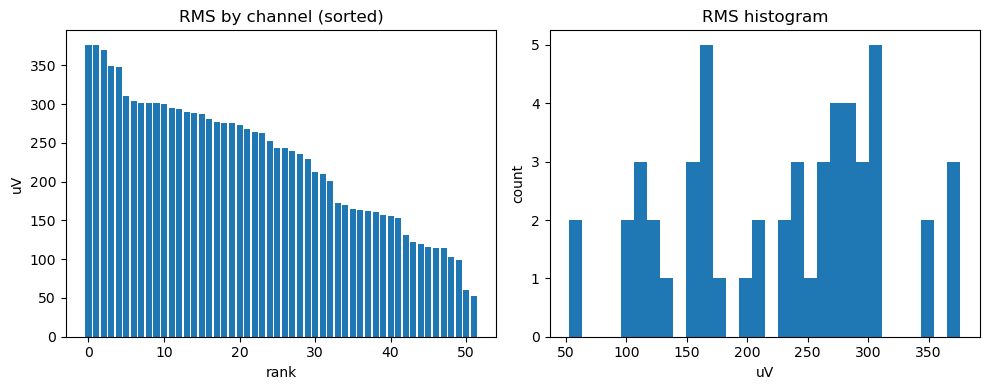


Noisy channel suggestion (median=243.38 uV, MAD*1.4826=88.32 uV, thresh=508.35 uV)
  None flagged by threshold.


In [80]:
# Per-channel RMS (scaled traces).
PLOT_RMS = True
WINDOW_S = 10

fs = rec_slice.get_sampling_frequency()
if hasattr(rec_slice, 'get_num_samples'):
    total = rec_slice.get_num_samples(0)
else:
    total = rec_slice.get_num_frames(0)
end = min(int(fs * WINDOW_S), total)
traces = get_traces_scaled(rec_slice, start_frame=0, end_frame=end)
rms = np.sqrt(np.mean(traces**2, axis=0))
ch_ids = np.array(rec_slice.channel_ids)
pairs = list(zip(ch_ids, rms))
pairs.sort(key=lambda x: x[1], reverse=True)
print(f'RMS over first {end/fs:.2f}s (sorted by RMS, high-to-low):')
for ch, val in pairs:
    print(f'  {ch}: {val:.2f} uV')

if PLOT_RMS:
    sorted_vals = [p[1] for p in pairs]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].bar(range(len(sorted_vals)), sorted_vals)
    axes[0].set_title('RMS by channel (sorted)')
    axes[0].set_xlabel('rank')
    axes[0].set_ylabel('uV')
    axes[1].hist(rms, bins=30)
    axes[1].set_title('RMS histogram')
    axes[1].set_xlabel('uV')
    axes[1].set_ylabel('count')
    plt.tight_layout()
    plt.show()

# Noisy channel suggestion (robust thresholding).
rms_vals = np.array([v for _, v in pairs], dtype=float)
med = np.median(rms_vals)
mad = np.median(np.abs(rms_vals - med))
mad_scale = 1.4826 * mad if mad > 0 else 0.0
thresh = med + 3.0 * mad_scale if mad_scale > 0 else med * 2.0
flagged = [(ch, v) for ch, v in pairs if v >= thresh]
print()
print(f"Noisy channel suggestion (median={med:.2f} uV, MAD*1.4826={mad_scale:.2f} uV, thresh={thresh:.2f} uV)")
if not flagged:
    print("  None flagged by threshold.")
else:
    for ch, v in flagged:
        print(f"  {ch}: {v:.2f} uV")


### Probe layout (RMS overlay)
Plot probe geometry with RMS coloring.
Expected: a probe scatter plot if geometry is available.


Layout source: rec_sc2


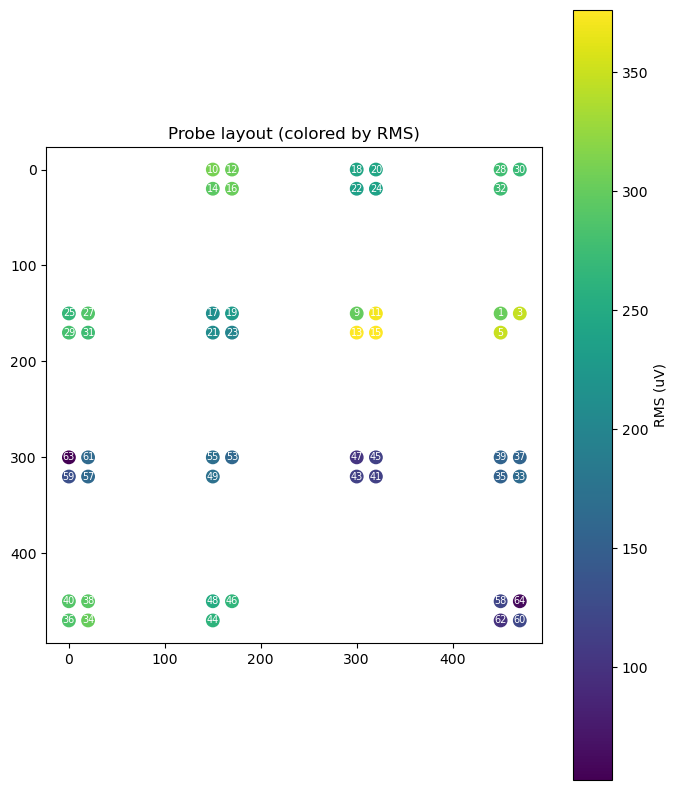

In [83]:
# Tetrode-only. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping tetrode-only cell (set RUN_TETRODE_CHECKS=True to run).')
else:
    if "pairs" not in globals():
        print("RMS data not found; run the RMS noise check cell first.")
    else:
        # Probe layout scatter (RMS-colored) based on SC2 geometry when available.
        layout_rec = globals().get('rec_sc2') or (rec_slice if 'rec_slice' in globals() else None)
        if layout_rec is not None:
            src_label = 'rec_sc2' if globals().get('rec_sc2') is layout_rec else 'rec_slice'
            print(f'Layout source: {src_label}')
        try:
            locs = layout_rec.get_channel_locations()
            ch_ids = list(layout_rec.channel_ids)
        except Exception as exc:
            print("channel_locations not found; geometry may not be attached:", exc)
            locs = None
            ch_ids = []

        if locs is None:
            print("No channel locations available; skipping RMS layout plot.")
        else:
            rms_dict = dict(pairs)
            positions = []
            labels = []
            colors = []
            for ch, pos in zip(ch_ids, locs):
                positions.append(pos)
                labels.append(ch)
                colors.append(rms_dict.get(ch, 0))

            positions = np.array(positions)
            colors = np.array(colors)

            fig, ax = plt.subplots(figsize=(8, 10))
            sc = ax.scatter(positions[:, 0], positions[:, 1], s=80, c=colors, cmap="viridis")
            for (x, y), ch in zip(positions, labels):
                label = str(ch)
                if label.startswith('CH'):
                    label = label[2:]
                ax.text(x, y, label, fontsize=7, ha="center", va="center", color="white")
            ax.set_title("Probe layout (colored by RMS)")
            ax.set_aspect("equal", adjustable="box")
            ax.invert_yaxis()
            cbar = plt.colorbar(sc, ax=ax)
            cbar.set_label("RMS (uV)")
            plt.show()


### Trace snippet + high-pass
Preview raw/HP-filtered snippet for quick sanity.
Expected: time-series plots for raw and high-pass traces.


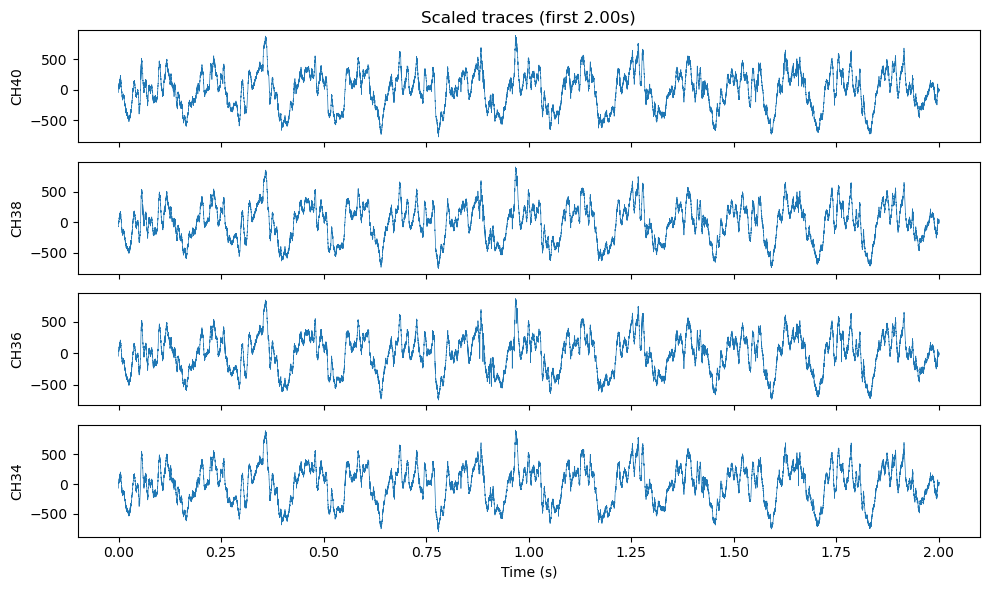

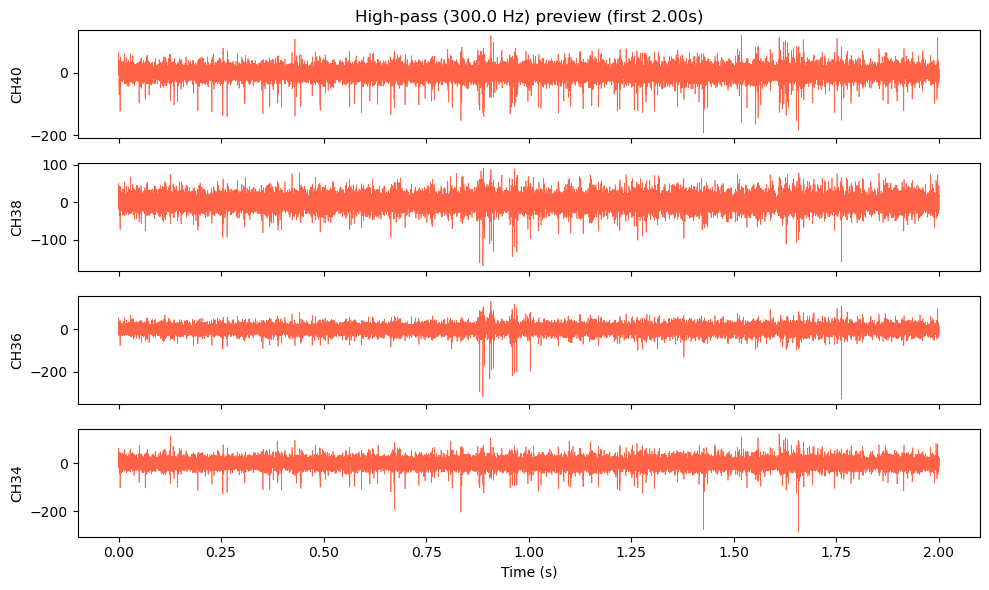

In [84]:
FREQ_MIN = 300.0

fs = rec_slice.get_sampling_frequency()
if hasattr(rec_slice, 'get_num_samples'):
    total = rec_slice.get_num_samples(0)
else:
    total = rec_slice.get_num_frames(0)
duration = min(2.0, total / fs)
end = int(duration * fs)
traces_snippet = get_traces_scaled(rec_slice, start_frame=0, end_frame=end)
t = np.arange(end) / fs
ch_indices = list(range(min(4, traces_snippet.shape[1])))
fig, axes = plt.subplots(len(ch_indices), 1, figsize=(10, 6), sharex=True)
for i, ch_idx in enumerate(ch_indices):
    axes[i].plot(t, traces_snippet[:, ch_idx], lw=0.5)
    axes[i].set_ylabel(str(rec_slice.channel_ids[ch_idx]))
axes[-1].set_xlabel('Time (s)')
axes[0].set_title(f'Scaled traces (first {duration:.2f}s)')
plt.tight_layout()
plt.show()

rec_hp = spre.highpass_filter(rec_slice, freq_min=FREQ_MIN)
traces_hp = get_traces_scaled(rec_hp, start_frame=0, end_frame=end)
fig, axes = plt.subplots(len(ch_indices), 1, figsize=(10, 6), sharex=True)
for i, ch_idx in enumerate(ch_indices):
    axes[i].plot(t, traces_hp[:, ch_idx], lw=0.5, color='tomato')
    axes[i].set_ylabel(str(rec_slice.channel_ids[ch_idx]))
axes[-1].set_xlabel('Time (s)')
axes[0].set_title(f'High-pass ({FREQ_MIN} Hz) preview (first {duration:.2f}s)')
plt.tight_layout()
plt.show()


### Power spectrum check
Compute a simple PSD for one channel.

Run the trace snippet cell first to populate `traces_snippet`.
Expected: a PSD plot (or a prompt to run the snippet cell).


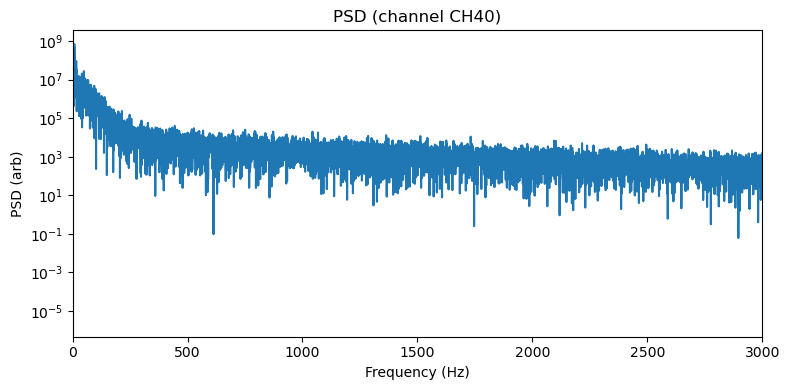

In [61]:
if "traces_snippet" not in globals() or "fs" not in globals():
    print("Trace snippet not found; run the trace snippet cell first.")
else:
    # Simple PSD on one channel (scaled snippet).
    ch_idx = 0
    sig = traces_snippet[:, ch_idx] - np.mean(traces_snippet[:, ch_idx])
    freqs = np.fft.rfftfreq(sig.size, d=1.0/fs)
    psd = (np.abs(np.fft.rfft(sig)) ** 2) / sig.size
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.semilogy(freqs, psd)
    ax.set_xlim(0, 3000)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (arb)')
    ax.set_title(f'PSD (channel {rec_slice.channel_ids[ch_idx]})')
    plt.tight_layout()
    plt.show()


### CAR + preprocessing sanity check
Compare raw vs CAR stats; optional plots and preprocessing demo.
Expected: before/after CAR stats and (optional) plots.



--- channel-sliced ---
CAR mode: global
n_channels: 52
native dtype: int16
has_probe: True
gain_to_uV: present; median 0.195000, unique 1
snippet dtype: float32
snippet stats (scaled if available): min -1050.27, max 1114.42, mean -2.93
snippet median (scaled if available): 2.34
snippet RMS (scaled if available): 249.65
CAR groups: 1; size range: 52-52
CAR snippet dtype: float32
CAR snippet stats (scaled if available): min -760.69, max 918.06, mean 2.67
CAR snippet median (scaled if available): 0.00
CAR snippet RMS (scaled if available): 147.34
global CAR: groups 1 (size range 52-52, dropped 0); mean 2.67, median 0.00, RMS 147.34
tetrode CAR: groups 14 (size range 3-4, dropped 2); mean 0.14, median 0.00, RMS 38.01


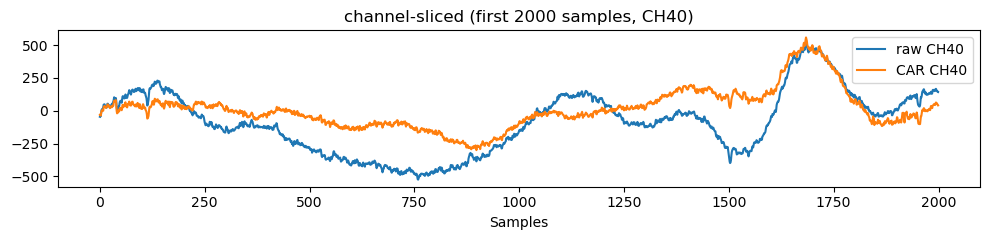

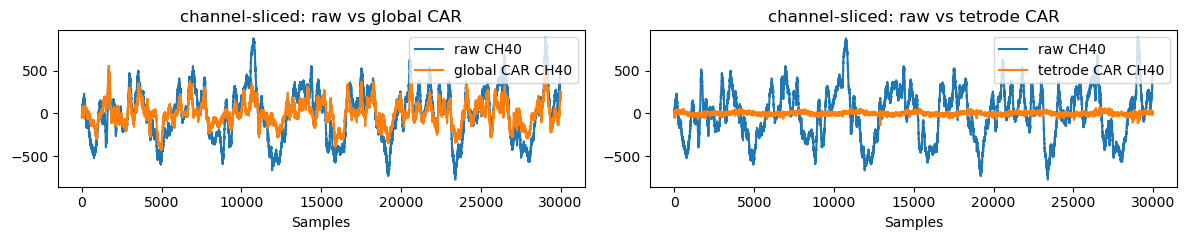


--- Bipolar check (channel-sliced, CH40) ---
global CAR: not enough high-amplitude samples (hits=0)
tetrode CAR: not enough high-amplitude samples (hits=0)

--- Preprocessing demo (rec_slice) ---
Pipeline: sequential
Groups for CAR: 1
raw stats (scaled if available): min -1050.27, max 1114.42, mean -2.93
bp stats (scaled if available): min -694.01, max 255.64, mean 0.00
car stats (scaled if available): min -702.39, max 257.20, mean -1.13
white stats (scaled if available): min -6.48, max 2.19, mean -0.01


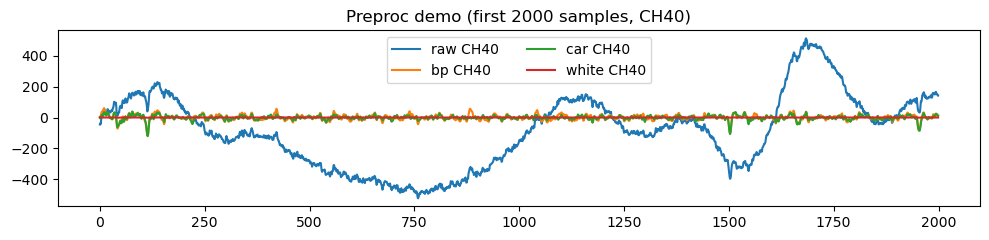

In [62]:
# Tetrode-only. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping tetrode-only cell (set RUN_TETRODE_CHECKS=True to run).')
else:
    from spikeinterface.preprocessing import common_reference

    CAR_MODE = "global"  # "tetrode" or "global"
    CAR_OPERATOR = "median"  # "median" or "average"
    COMPARE_CAR_MODES = True  # print global vs tetrode CAR stats side-by-side
    PLOT_CAR = True
    PLOT_CAR_COMPARE = True  # plot raw vs global and raw vs tetrode
    PLOT_SAMPLES = 2000
    PLOT_STRIDE = 1
    PLOT_CH_ID = None  # e.g., "CH40" (takes precedence if set)
    PLOT_CH_INDEX = 0  # fallback index
    SNIP_SECONDS = 1
    BIPOLAR_CHECK = True
    BIPOLAR_Z = 3.0  # z-score threshold on raw trace
    BIPOLAR_MIN_HITS = 25  # minimum suprathreshold samples to report
    BIPOLAR_MODES = ("global", "tetrode")


    RUN_PREPROC_DEMO = True
    PREPROC_MODE = "rec_slice"
    PREPROC_PIPELINE = "sequential"  # "sequential" or "independent"
    PREPROC_PLOT = True
    PREPROC_SHOW = ("raw", "bp", "car", "white")  # subset to show
    FREQ_MIN, FREQ_MAX = 300, 6000
    PREPROC_SECONDS = 1
    PREPROC_PLOT_SAMPLES = 2000
    PREPROC_PLOT_STRIDE = 1
    WHITEN_MODE = "global"  # "global" or "local"
    WHITEN_RADIUS_UM = 100.0  # used when WHITEN_MODE == "local"

    def get_targets():
        targets = []
        if "rec_slice" in globals():
            targets.append(("channel-sliced", rec_slice))
        if not targets:
            targets.append(("full recording", recording))
        return targets

    def build_groups(rec_obj, mode):
        ordered = list(rec_obj.channel_ids)
        if mode == "global":
            return [ordered], 0
        if 'base_groups' not in globals():
            print("base_groups not found; falling back to global CAR")
            return [ordered], 0
        present = set(ordered)
        raw_groups = [[ch for ch in grp if ch in present] for grp in base_groups]
        kept = [g for g in raw_groups if g]
        dropped = len(raw_groups) - len(kept)
        return kept, dropped

    def pick_plot_channel(rec_obj):
        ch_ids = list(rec_obj.channel_ids)
        if not ch_ids:
            raise RuntimeError("No channels available for plotting.")
        if PLOT_CH_ID is not None:
            for idx, ch in enumerate(ch_ids):
                if ch == PLOT_CH_ID or str(ch) == str(PLOT_CH_ID):
                    return idx, ch
            print(f"Warning: PLOT_CH_ID {PLOT_CH_ID} not found; falling back to index {PLOT_CH_INDEX}")
        try:
            idx = int(PLOT_CH_INDEX)
        except Exception:
            idx = 0
        idx = max(0, min(idx, len(ch_ids) - 1))
        return idx, ch_ids[idx]

    snippets = []
    for label, rec_obj in get_targets():
        print()
        print(f"--- {label} ---")
        print(f"CAR mode: {CAR_MODE}")
        fs = rec_obj.get_sampling_frequency()

        print("n_channels:", rec_obj.get_num_channels())
        print("native dtype:", rec_obj.get_dtype())
        print("has_probe:", getattr(rec_obj, "has_probe", lambda: False)())

        gain = rec_obj.get_property("gain_to_uV") if "gain_to_uV" in rec_obj.get_property_keys() else None
        if gain is None:
            print("gain_to_uV: missing")
        else:
            g = np.asarray(gain)
            uniq = np.unique(g)
            print(f"gain_to_uV: present; median {np.median(g):.6f}, unique {len(uniq)}")

        snippet = get_traces_scaled(rec_obj, start_frame=0, end_frame=int(fs * SNIP_SECONDS))
        print("snippet dtype:", snippet.dtype)
        print(
            f"snippet stats (scaled if available): min {snippet.min():.2f}, max {snippet.max():.2f}, mean {snippet.mean():.2f}"
        )
        print(f"snippet median (scaled if available): {np.median(snippet):.2f}")
        print(f"snippet RMS (scaled if available): {np.sqrt(np.mean(snippet**2)):.2f}")

        groups_car, dropped = build_groups(rec_obj, CAR_MODE)
        if groups_car:
            sizes = [len(g) for g in groups_car]
            print(f"CAR groups: {len(groups_car)}; size range: {min(sizes)}-{max(sizes)}")
            if dropped:
                print(f"CAR groups dropped (empty): {dropped}")
        else:
            print("CAR groups: 0")

        rec_car = common_reference(rec_obj, reference="global", operator=CAR_OPERATOR, groups=groups_car)
        snip_car = get_traces_scaled(rec_car, start_frame=0, end_frame=int(fs * SNIP_SECONDS))
        print("CAR snippet dtype:", snip_car.dtype)
        print(
            f"CAR snippet stats (scaled if available): min {snip_car.min():.2f}, max {snip_car.max():.2f}, mean {snip_car.mean():.2f}"
        )
        print(f"CAR snippet median (scaled if available): {np.median(snip_car):.2f}")
        print(f"CAR snippet RMS (scaled if available): {np.sqrt(np.mean(snip_car**2)):.2f}")

        if COMPARE_CAR_MODES:
            for mode in ("global", "tetrode"):
                groups_cmp, dropped_cmp = build_groups(rec_obj, mode)
                rec_cmp = common_reference(rec_obj, reference="global", operator=CAR_OPERATOR, groups=groups_cmp)
                snip_cmp = get_traces_scaled(rec_cmp, start_frame=0, end_frame=int(fs * SNIP_SECONDS))
                rms = np.sqrt(np.mean(snip_cmp**2))
                mean = float(np.mean(snip_cmp))
                median = float(np.median(snip_cmp))
                if groups_cmp:
                    sizes = [len(g) for g in groups_cmp]
                    size_range = f"{min(sizes)}-{max(sizes)}"
                else:
                    size_range = "n/a"
                print(
                    f"{mode} CAR: groups {len(groups_cmp)} (size range {size_range}, dropped {dropped_cmp}); "
                    f"mean {mean:.2f}, median {median:.2f}, RMS {rms:.2f}"
                )

        plot_idx, plot_id = pick_plot_channel(rec_obj)
        if PLOT_CAR or PLOT_CAR_COMPARE:
            snippets.append((label, snippet, snip_car, plot_id, plot_idx))

    if PLOT_CAR and snippets:
        rows = len(snippets)
        fig, axes = plt.subplots(rows, 1, figsize=(10, 2.5 * rows), sharex=True)
        if rows == 1:
            axes = [axes]

        for ax, (label, raw, car, ch_id, ch_idx) in zip(axes, snippets):
            n = min(PLOT_SAMPLES, raw.shape[0])
            plot_slice = slice(0, n, PLOT_STRIDE)
            ax.plot(raw[plot_slice, ch_idx], label=f"raw {ch_id}")
            ax.plot(car[plot_slice, ch_idx], label=f"CAR {ch_id}")
            ax.set_title(f"{label} (first {n} samples, {ch_id})")
            ax.legend(loc="upper right")

        axes[-1].set_xlabel("Samples")
        plt.tight_layout()
        plt.show()
        plt.close(fig)

    if PLOT_CAR_COMPARE:
        compare_rows = len(snippets)
        if compare_rows == 0:
            print("No snippets available for compare plot.")
        else:
            fig, axes = plt.subplots(compare_rows, 2, figsize=(12, 2.5 * compare_rows), sharex=True)
            if compare_rows == 1:
                axes = [axes]
            for row_idx, (label, raw, car, ch_id, ch_idx) in enumerate(snippets):
                rec_obj = rec_slice if label == "channel-sliced" and 'rec_slice' in globals() else recording
                fs = rec_obj.get_sampling_frequency()
                end = min(raw.shape[0], int(fs * SNIP_SECONDS))
                snippet_raw = get_traces_scaled(rec_obj, start_frame=0, end_frame=end)

                groups_global, _ = build_groups(rec_obj, "global")
                rec_global = common_reference(rec_obj, reference="global", operator=CAR_OPERATOR, groups=groups_global)
                snip_global = get_traces_scaled(rec_global, start_frame=0, end_frame=end)

                groups_tet, _ = build_groups(rec_obj, "tetrode")
                rec_tet = common_reference(rec_obj, reference="global", operator=CAR_OPERATOR, groups=groups_tet)
                snip_tet = get_traces_scaled(rec_tet, start_frame=0, end_frame=end)

                ax_g = axes[row_idx][0]
                ax_t = axes[row_idx][1]
                ax_g.plot(snippet_raw[:, ch_idx], label=f"raw {ch_id}")
                ax_g.plot(snip_global[:, ch_idx], label=f"global CAR {ch_id}")
                ax_g.set_title(f"{label}: raw vs global CAR")
                ax_g.legend(loc="upper right")

                ax_t.plot(snippet_raw[:, ch_idx], label=f"raw {ch_id}")
                ax_t.plot(snip_tet[:, ch_idx], label=f"tetrode CAR {ch_id}")
                ax_t.set_title(f"{label}: raw vs tetrode CAR")
                ax_t.legend(loc="upper right")

            axes[-1][0].set_xlabel("Samples")
            axes[-1][1].set_xlabel("Samples")
            plt.tight_layout()
            plt.show()


    if BIPOLAR_CHECK:
        # Bipolar check: compare raw vs CAR sign at large deflections.
        def bipolar_score(raw_vec, car_vec, z_thresh, min_hits):
            raw_vec = raw_vec - np.median(raw_vec)
            car_vec = car_vec - np.median(car_vec)
            thr = z_thresh * np.std(raw_vec)
            hits = np.where(np.abs(raw_vec) >= thr)[0]
            if hits.size < min_hits:
                return None, hits.size
            flips = np.sign(raw_vec[hits]) != np.sign(car_vec[hits])
            return float(np.mean(flips)), hits.size

        if 'rec_slice' in globals():
            rec_obj = rec_slice
            label = 'channel-sliced'
        else:
            rec_obj = recording
            label = 'recording'

        try:
            fs = rec_obj.get_sampling_frequency()
            if hasattr(rec_obj, 'get_num_samples'):
                total = rec_obj.get_num_samples(0)
            else:
                total = rec_obj.get_num_frames(0)
            end = min(int(fs * SNIP_SECONDS), total)
            plot_idx, plot_id = pick_plot_channel(rec_obj)
            raw = get_traces_scaled(rec_obj, start_frame=0, end_frame=end)[:, plot_idx]
            print()
            print(f"--- Bipolar check ({label}, {plot_id}) ---")
            for mode in BIPOLAR_MODES:
                groups_cmp, _ = build_groups(rec_obj, mode)
                rec_cmp = common_reference(rec_obj, reference='global', operator=CAR_OPERATOR, groups=groups_cmp)
                car = get_traces_scaled(rec_cmp, start_frame=0, end_frame=end)[:, plot_idx]
                score, hits = bipolar_score(raw, car, BIPOLAR_Z, BIPOLAR_MIN_HITS)
                if score is None:
                    print(f"{mode} CAR: not enough high-amplitude samples (hits={hits})")
                else:
                    print(f"{mode} CAR: sign-flip fraction {score:.2f} (hits={hits})")
        except Exception as exc:
            print(f"Bipolar check failed: {exc}")

    if RUN_PREPROC_DEMO:
        if PREPROC_MODE == "rec_slice" and 'rec_slice' in globals():
            rec_demo = rec_slice
            demo_label = "rec_slice"
        else:
            rec_demo = recording
            demo_label = "recording"

        rec_bp = spre.bandpass_filter(rec_demo, freq_min=FREQ_MIN, freq_max=FREQ_MAX, margin_ms=10)
        groups_car, _ = build_groups(rec_demo, CAR_MODE)
        whiten_mode = WHITEN_MODE
        if whiten_mode == "local":
            try:
                locs = rec_demo.get_channel_locations()
            except Exception:
                locs = None
            if locs is None:
                print("Warning: local whitening requested but channel locations missing; falling back to global.")
                whiten_mode = "global"
        whiten_kwargs = dict(dtype="float32", mode=whiten_mode)
        if whiten_mode == "local":
            whiten_kwargs["radius_um"] = WHITEN_RADIUS_UM
        if PREPROC_PIPELINE == "independent":
            rec_car = spre.common_reference(rec_demo, reference="global", operator=CAR_OPERATOR, groups=groups_car)
            rec_white = spre.whiten(rec_demo, **whiten_kwargs)
        else:
            rec_car = spre.common_reference(rec_bp, reference="global", operator=CAR_OPERATOR, groups=groups_car)
            rec_white = spre.whiten(rec_car, **whiten_kwargs)

        fs = rec_demo.get_sampling_frequency()
        end = int(fs * PREPROC_SECONDS)
        raw = get_traces_scaled(rec_demo, start_frame=0, end_frame=end)
        bp = get_traces_scaled(rec_bp, start_frame=0, end_frame=end)
        car = get_traces_scaled(rec_car, start_frame=0, end_frame=end)
        white = get_traces_scaled(rec_white, start_frame=0, end_frame=end)

        print()
        print(f"--- Preprocessing demo ({demo_label}) ---")
        print(f"Pipeline: {PREPROC_PIPELINE}")
        print(f"Groups for CAR: {len(groups_car)}")
        order = ["raw", "bp", "car", "white"]
        if PREPROC_SHOW is None:
            show = set(order)
        elif isinstance(PREPROC_SHOW, str):
            show = {PREPROC_SHOW.lower()}
        else:
            show = {s.lower() for s in PREPROC_SHOW}
        if not show:
            show = set(order)

        for name in order:
            if name not in show:
                continue
            arr = {"raw": raw, "bp": bp, "car": car, "white": white}[name]
            print(
                f"{name} stats (scaled if available): min {arr.min():.2f}, max {arr.max():.2f}, mean {arr.mean():.2f}"
            )

        if PREPROC_PLOT:
            ch0 = rec_demo.channel_ids[0]
            n = min(PREPROC_PLOT_SAMPLES, raw.shape[0])
            plot_slice = slice(0, n, PREPROC_PLOT_STRIDE)
            plt.figure(figsize=(10, 2.5))
            if "raw" in show:
                plt.plot(raw[plot_slice, 0], label=f"raw {ch0}")
            if "bp" in show:
                plt.plot(bp[plot_slice, 0], label=f"bp {ch0}")
            if "car" in show:
                plt.plot(car[plot_slice, 0], label=f"car {ch0}")
            if "white" in show:
                plt.plot(white[plot_slice, 0], label=f"white {ch0}")
            plt.legend(ncol=2)
            plt.title(f"Preproc demo (first {n} samples, {ch0})")
            plt.tight_layout()
            plt.show()


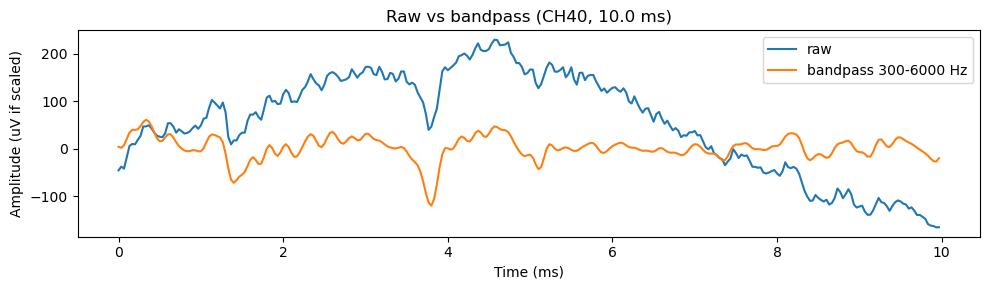

In [63]:
# Waveform sanity check: raw vs bandpass.

WF_START_SEC = 0.0
WF_SECONDS = 0.01  # 10 ms window; increase or shift WF_START_SEC to capture a spike
WF_CH_ID = None  # e.g., 'CH40' (takes precedence if set)
WF_CH_INDEX = 0
WF_BP_MIN = 300
WF_BP_MAX = 6000

def pick_wf_channel(rec_obj):
    ch_ids = list(rec_obj.channel_ids)
    if not ch_ids:
        raise RuntimeError('No channels available for waveform plot.')
    if WF_CH_ID is not None:
        for idx, ch in enumerate(ch_ids):
            if ch == WF_CH_ID or str(ch) == str(WF_CH_ID):
                return idx, ch
        print(f'Warning: WF_CH_ID {WF_CH_ID} not found; falling back to index {WF_CH_INDEX}')
    try:
        idx = int(WF_CH_INDEX)
    except Exception:
        idx = 0
    idx = max(0, min(idx, len(ch_ids) - 1))
    return idx, ch_ids[idx]

rec_obj = rec_slice if 'rec_slice' in globals() else recording
fs = rec_obj.get_sampling_frequency()
start_frame = int(WF_START_SEC * fs)
end_frame = min(start_frame + int(WF_SECONDS * fs), rec_obj.get_num_samples(0))

if end_frame <= start_frame:
    print('Waveform window is empty; adjust WF_START_SEC/WF_SECONDS.')
else:
    wf_idx, wf_id = pick_wf_channel(rec_obj)
    raw = get_traces_scaled(rec_obj, start_frame=start_frame, end_frame=end_frame)[:, wf_idx]
    rec_bp = spre.bandpass_filter(rec_obj, freq_min=WF_BP_MIN, freq_max=WF_BP_MAX, margin_ms=10)
    bp = get_traces_scaled(rec_bp, start_frame=start_frame, end_frame=end_frame)[:, wf_idx]

    t_ms = (np.arange(raw.shape[0]) / fs) * 1000.0
    plt.figure(figsize=(10, 3))
    plt.plot(t_ms, raw, label='raw')
    plt.plot(t_ms, bp, label=f'bandpass {WF_BP_MIN}-{WF_BP_MAX} Hz')
    plt.title(f'Raw vs bandpass ({wf_id}, {WF_SECONDS*1000:.1f} ms)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (uV if scaled)')
    plt.legend()
    plt.tight_layout()
    plt.show()


### Performance metrics (optional)
Time and memory spot-checks for preprocessing.
Expected: timing and memory deltas when enabled.


In [64]:
RUN_PERF = False  # set True to run performance timing
if not RUN_PERF:
    print('Performance metrics skipped (RUN_PERF=False).')
else:
    # Performance timing/memory.
    import time
    import psutil

    process = psutil.Process()
    initial_memory = process.memory_info().rss / 1024 / 1024  # MB
    start_time = time.perf_counter()

    # Simulate preprocessing if needed.
    if 'rec_preprocessed' not in locals():
        rec_preprocessed = spre.bandpass_filter(recording, freq_min=300, freq_max=6000)
        if 'groups' in globals() and groups:
            rec_preprocessed = spre.common_reference(rec_preprocessed, reference="global", operator="median", groups=groups)

    end_time = time.perf_counter()
    final_memory = process.memory_info().rss / 1024 / 1024  # MB
    elapsed = end_time - start_time

    print(f"Preprocessing time: {elapsed:.4f} seconds")
    print(f"Memory usage: {initial_memory:.1f} MB -> {final_memory:.1f} MB (delta: {final_memory - initial_memory:.1f} MB)")
    print("Performance metrics complete.")


Performance metrics skipped (RUN_PERF=False).


In [65]:
# Load analyzer from disk (optional).
from spikeinterface.core import load_sorting_analyzer

LOAD_ANALYZER = False
ANALYZER_PATH = None  # set to a specific folder to override auto-pick

ANALYZER_SOURCE = "rec_sc2" if getattr(pipe, "ANALYZER_FROM_SORTER", False) else "rec_export"
print(f"Analyzer source preference (pipeline): {ANALYZER_SOURCE}")

if LOAD_ANALYZER:
    analyzer_base = Path(base_out) / "sc2_outputs"
    if ANALYZER_PATH is None:
        candidates = sorted(analyzer_base.glob("analyzer_*"), key=lambda p: p.stat().st_mtime)
        if not candidates:
            print(f"No analyzer folders found under {analyzer_base}")
        else:
            ANALYZER_PATH = candidates[-1]
    if ANALYZER_PATH:
        analyzer_sc2 = load_sorting_analyzer(ANALYZER_PATH)
        print(f"Loaded analyzer: {ANALYZER_PATH}")
else:
    print("Analyzer load skipped; set LOAD_ANALYZER=True to load from disk.")


Analyzer source preference (pipeline): rec_sc2
Analyzer load skipped; set LOAD_ANALYZER=True to load from disk.


In [66]:
# Unit QC: spike counts + ISI (requires SortingAnalyzer).

RUN_UNIT_QC = False
UNIT_ID = None  # set to an explicit unit id (e.g., 0)
TOP_N = 10
ISI_MAX_MS = 100

if not RUN_UNIT_QC:
    print("Unit QC skipped; set RUN_UNIT_QC=True to run.")
else:
    analyzer_obj = globals().get("analyzer_sc2") or globals().get("analyzer")
    if analyzer_obj is None:
        print("No analyzer found; load one above or run the pipeline first.")
    else:
        sorting = analyzer_obj.sorting
        unit_ids = list(sorting.get_unit_ids())
        if not unit_ids:
            print("No units available.")
        else:
            # Spike counts.
            counts = {uid: sorting.get_unit_spike_train(uid).size for uid in unit_ids}
            top = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:TOP_N]
            print("Top units by spike count:")
            for uid, n in top:
                print(f"  unit {uid}: {n}")

            if UNIT_ID is None:
                UNIT_ID = top[0][0]

            spikes = sorting.get_unit_spike_train(UNIT_ID)
            fs = analyzer_obj.recording.get_sampling_frequency()
            try:
                total = analyzer_obj.recording.get_num_samples(0)
            except Exception:
                total = analyzer_obj.recording.get_num_frames(0)
            duration_s = total / fs if total else np.nan
            fr = (len(spikes) / duration_s) if duration_s else np.nan
            print(f"Unit {UNIT_ID}: spikes={len(spikes)}, firing_rate={fr:.2f} Hz")

            if len(spikes) > 1:
                isi_ms = np.diff(spikes) / fs * 1000.0
                plt.figure(figsize=(6, 3))
                plt.hist(isi_ms[isi_ms <= ISI_MAX_MS], bins=50, color="#4C78A8")
                plt.title(f"ISI histogram (unit {UNIT_ID})")
                plt.xlabel("ISI (ms)")
                plt.ylabel("Count")
                plt.tight_layout()
                plt.show()
            else:
                print("Not enough spikes for ISI histogram.")


Unit QC skipped; set RUN_UNIT_QC=True to run.


### Extra visualizations
Optional plots for raw/preprocessed traces.
Expected: trace plots when data are available.


Preproc check: mean|diff|=190.377 uV | raw std=249.634 uV | pre std=19.826 uV | corr=0.109


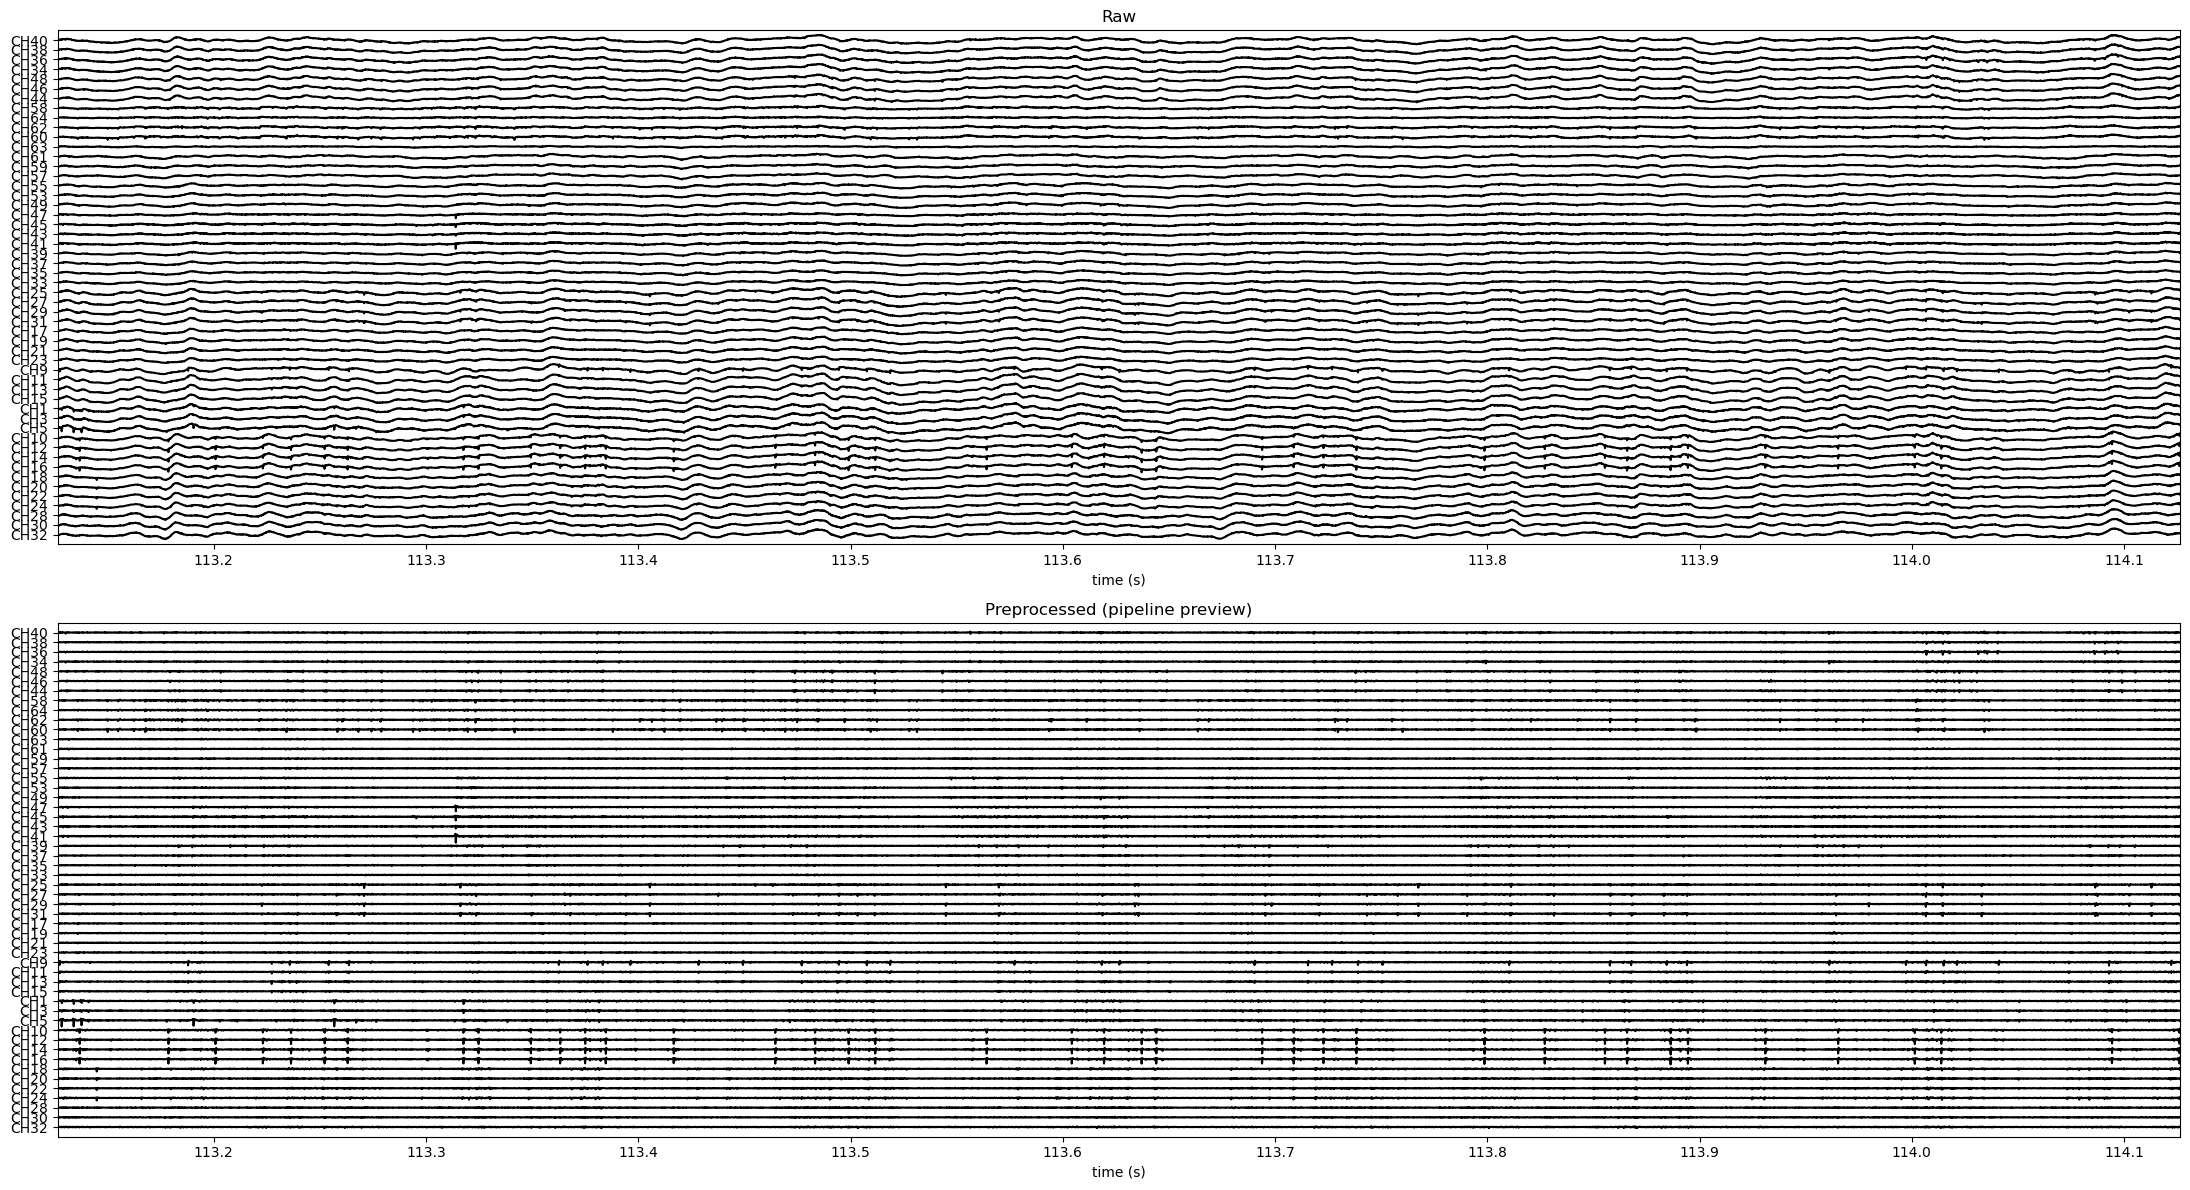

Visualizations complete.


In [71]:
# Extra visualizations (raw vs preprocessed only).
FIGSIZE = (22, 12)  # overall figure size for raw/preprocessed comparison
TRACE_FIGSIZE = (22, 10)  # single trace plot size
import spikeinterface.widgets as sw
import warnings

PLOT_SECONDS = 1.0
PLOT_START_SECONDS = 0.0
PLOT_CHANNEL_ORDER = "reverse"  # "native" or "reverse"

if 'recording' not in globals():
    print("Recording not loaded; run earlier cells.")
else:
    plot_rec = rec_slice if 'rec_slice' in globals() else recording
    fs = plot_rec.get_sampling_frequency()
    if hasattr(plot_rec, 'get_num_samples'):
        total = plot_rec.get_num_samples(0)
    else:
        total = plot_rec.get_num_frames(0)
    total_seconds = total / fs
    start_seconds = max(min(PLOT_START_SECONDS, max(total_seconds - PLOT_SECONDS, 0.0)), 0.0)
    if start_seconds != PLOT_START_SECONDS:
        print(f'Clamped PLOT_START_SECONDS from {PLOT_START_SECONDS} to {start_seconds:.3f}.')
    start_frame = int(start_seconds * fs)
    end_frame = min(int((start_seconds + PLOT_SECONDS) * fs), total)

    if end_frame <= start_frame:
        print("Plot window is empty; skipping trace plots.")
    else:
        plot_view = plot_rec.frame_slice(start_frame=start_frame, end_frame=end_frame)
        plot_channel_ids = list(plot_view.channel_ids)
        if PLOT_CHANNEL_ORDER == "reverse":
            plot_channel_ids = list(reversed(plot_channel_ids))

        # Build preprocessed preview if needed.
        if 'rec_preprocessed' not in locals():
            rec_preprocessed = None
            preproc_label = None
            try:
                if 'pipe' in globals():
                    rec_preprocessed = pipe.preprocess_for_sc2(plot_rec, groups=groups if 'groups' in globals() else None)
                    preproc_label = "Preprocessed (pipeline preview)"
                else:
                    import spikeinterface.preprocessing as spre
                    rec_preprocessed = spre.bandpass_filter(plot_rec, freq_min=300, freq_max=6000)
                    if 'groups' in globals() and groups:
                        rec_preprocessed = spre.common_reference(rec_preprocessed, reference="global", operator="median", groups=groups)
                    preproc_label = "Preprocessed (bandpass+CAR preview)"
            except Exception as exc:
                print(f'Failed to build preprocessed preview: {exc}')
                rec_preprocessed = None

        if 'rec_preprocessed' in locals() and rec_preprocessed is not None:
            if hasattr(rec_preprocessed, 'get_num_samples'):
                total_pre = rec_preprocessed.get_num_samples(0)
            else:
                total_pre = rec_preprocessed.get_num_frames(0)
            end_frame_pre = min(end_frame, total_pre)
            if end_frame_pre <= start_frame:
                print('Preprocessed plot window is empty; plotting raw only.')
                fig, ax = plt.subplots(1, 1, figsize=TRACE_FIGSIZE)
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', message='You have selected a time after the end of the segment.*')
                    sw.plot_traces(plot_view, channel_ids=plot_channel_ids, ax=ax, show_channel_ids=True, add_legend=False)
                ax.set_title("Raw")
                plt.tight_layout()
                plt.show()
            else:
                preproc_view = rec_preprocessed.frame_slice(start_frame=start_frame, end_frame=end_frame_pre)
                # Numeric sanity check: raw vs preprocessed (should differ).
                try:
                    import numpy as np
                    raw_tr = get_traces_scaled(plot_view, start_frame=0, end_frame=None)
                    pre_tr = get_traces_scaled(preproc_view, start_frame=0, end_frame=None)
                    min_len = min(raw_tr.shape[0], pre_tr.shape[0])
                    min_ch = min(raw_tr.shape[1], pre_tr.shape[1])
                    raw_tr = raw_tr[:min_len, :min_ch]
                    pre_tr = pre_tr[:min_len, :min_ch]
                    diff = pre_tr - raw_tr
                    mean_abs = float(np.mean(np.abs(diff)))
                    raw_std = float(np.std(raw_tr))
                    pre_std = float(np.std(pre_tr))
                    corr = float(np.corrcoef(raw_tr.ravel(), pre_tr.ravel())[0, 1])
                    print(f'Preproc check: mean|diff|={mean_abs:.3f} uV | raw std={raw_std:.3f} uV | pre std={pre_std:.3f} uV | corr={corr:.3f}')
                except Exception as exc:
                    print(f'Preproc check skipped: {exc}')
                fig, axes = plt.subplots(2, 1, figsize=FIGSIZE)
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', message='You have selected a time after the end of the segment.*')
                    sw.plot_traces(plot_view, channel_ids=plot_channel_ids, ax=axes[0], show_channel_ids=True, add_legend=False)
                axes[0].set_title("Raw")
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', message='You have selected a time after the end of the segment.*')
                    sw.plot_traces(preproc_view, channel_ids=plot_channel_ids, ax=axes[1], show_channel_ids=True, add_legend=False)
                axes[1].set_title(preproc_label or "Preprocessed")
                plt.tight_layout()
                plt.show()
        else:
            print("No preprocessed recording to compare; plotting raw only.")
            fig, ax = plt.subplots(1, 1, figsize=TRACE_FIGSIZE)
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', message='You have selected a time after the end of the segment.*')
                sw.plot_traces(plot_view, channel_ids=plot_channel_ids, ax=ax, show_channel_ids=True, add_legend=False)
            ax.set_title("Raw")
            plt.tight_layout()
            plt.show()

print("Visualizations complete.")
